# OS11 - Exercises 9-11

In [1]:
from sympy import *

In [2]:
import numpy as np

In [3]:
import scipy.linalg as linalg

In [4]:
from scipy.optimize import linprog

In [5]:
import matplotlib.pyplot as plt

### Previous functions useful here

In [6]:
def nodes_indexer(named_nodes):
    nodes = {}
    for i in range(len(named_nodes)):
        nodes[named_nodes[i]] = i
    return nodes

In [7]:
def ANMatrix_from_arcs(graph, num_nodes):
    num_arcs = len(graph)
    arcs = []
    MN = np.zeros((num_nodes, num_arcs)).astype(int)
    for a in range(len(graph)):
        MN[graph[a][0][0], a] = 1
        MN[graph[a][0][1], a] = -1
        arcs.append(graph[a][0])
    return MN

In [8]:
def print_path(graph, selected_nodes):
    s = ''
    sep = ' -> '
    s += sep
    for i in range(len(graph)):
        if selected_nodes[i] > 0.1:
            s += str(graph[i][0]) + sep
    return s

## Ex. 9 - SP time-restricted 

In [9]:
named_nodes = ['s', '2', '3', '4', '5', 't']   #node enumeration. Can be any non repeated inmutable.

In [10]:
nodes = nodes_indexer(named_nodes)

In [11]:
gen_graph = []

gen_graph.append((('s', '2'), (2,3)))   #distance, time
gen_graph.append((('s', '3'), (1,1)))

gen_graph.append((('2', '4'), (2,3)))
gen_graph.append((('2', 't'), (5,1)))

gen_graph.append((('3', '5'), (2,3)))

gen_graph.append((('4', 't'), (1,3)))

gen_graph.append((('5', 't'), (2,5)))

gen_graph


[(('s', '2'), (2, 3)),
 (('s', '3'), (1, 1)),
 (('2', '4'), (2, 3)),
 (('2', 't'), (5, 1)),
 (('3', '5'), (2, 3)),
 (('4', 't'), (1, 3)),
 (('5', 't'), (2, 5))]

Graph data is in named form, I need it in indexed form:

In [12]:
indexed_graph = [((nodes[a[0][0]], nodes[a[0][1]]), a[1]) for a in gen_graph]
indexed_graph

[((0, 1), (2, 3)),
 ((0, 2), (1, 1)),
 ((1, 3), (2, 3)),
 ((1, 5), (5, 1)),
 ((2, 4), (2, 3)),
 ((3, 5), (1, 3)),
 ((4, 5), (2, 5))]

Now, I can create the arcs-nodes matrix

In [13]:
A = ANMatrix_from_arcs(indexed_graph, len(nodes))
A

array([[ 1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0, -1,  0, -1, -1]])

Cost function:

In [14]:
costos = [a[1][0] for a in gen_graph]
c = np.array(costos)

c

array([2, 1, 2, 5, 2, 1, 2])

Nodes balance b:
    

In [15]:
b = np.zeros((len(nodes)))
b[nodes['s']] = 1 
b[nodes['t']] = -1 

b

array([ 1.,  0.,  0.,  0.,  0., -1.])

D.V. bounds:

In [16]:
limites = [(0, None) for a in gen_graph]
limites

[(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

Travel time for each arc:

In [17]:
t_j = [[a[1][1] for a in gen_graph]]
t_j = np.array(t_j)
t_j

array([[3, 1, 3, 1, 3, 3, 5]])

Maximum time available:

In [18]:
T = np.array([9])
T

array([9])

### Resolution

In [19]:
r = linprog(c=c, A_eq = A, b_eq = b, bounds = limites, A_ub= t_j, b_ub=T, method='revised simplex')

<ipython-input-19-0c828d44b360>:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c, A_eq = A, b_eq = b, bounds = limites, A_ub= t_j, b_ub=T, method='revised simplex')


In [20]:
r

     con: array([0., 0., 0., 0., 0., 0.])
     fun: 5.0
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([0.])
  status: 0
 success: True
       x: array([0., 1., 0., 0., 1., 0., 1.])

### Results

In [21]:
print_path(gen_graph, r.x)

" -> ('s', '3') -> ('3', '5') -> ('5', 't') -> "

### Second case, T=8 hs

In [22]:
T = np.array([8])
T

array([8])

In [23]:
r = linprog(c=c, A_eq = A, b_eq = b, bounds = limites, A_ub= t_j, b_ub=T, method='simplex')

<ipython-input-23-afe5f22800ef>:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c, A_eq = A, b_eq = b, bounds = limites, A_ub= t_j, b_ub=T, method='simplex')


In [24]:
r

     con: array([0., 0., 0., 0., 0., 0.])
     fun: 5.4
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([0.])
  status: 0
 success: True
       x: array([0.2, 0.8, 0. , 0.2, 0.8, 0. , 0.8])

In [25]:
r.fun

5.4

### Conclussions

With restriction Tmax = 9 hs problem works and solver found a solution equal to 5 hs.

When  we change restriction to 8 hs, solver fails to found a correct solution in our problem context despite being mathematically correct.

The fact that the case 8 hs is equally factible as the case 9 hs shows the resolution technique limitations.

## Ex. 10 - SP time-restricted with Lagrange relaxation 

### Problem data

Data is the same as Ex. 9, so we have cost function:

In [26]:
c

array([2, 1, 2, 5, 2, 1, 2])

Travel times:

In [27]:
t_j

array([[3, 1, 3, 1, 3, 3, 5]])

Max. time:

In [28]:
T = 8

Arc-Node matrix:

In [29]:
A

array([[ 1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0, -1,  0, -1, -1]])

Node balance:

In [30]:
b

array([ 1.,  0.,  0.,  0.,  0., -1.])

D. V. bounds:

In [31]:
limites

[(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

### Function definition

First I will define the Lagrangian function:

In [32]:
def L(lambda_):
    c_moño = c + t_j * lambda_
    r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')
    
    return -lambda_*T+r.fun, r

Using a guess I try a max lambda and compute values to restrict seach range:

In [33]:
lambda_max = 10.0
steps = 5

In [34]:
lambdas = [l*lambda_max/steps for l in range(0,steps+1)]
lambdas

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0]

In [35]:
results = [L(l)[0] for l in lambdas]
results

<ipython-input-32-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


[5.0, -1.0, -9.0, -17.0, -25.0, -33.0]

The best solution lies between 0 and 2.

We define a progrssive search funtion for finding maximum's interval.

In [36]:
def search_max(b, e, tol = 0.001):

    found = False
    
    while not found:    
        rango = [b + (e-b)/steps*i for i in range(steps+1)]
        valores = [L(l) for l in rango]
        
        minimo = valores[0][0]
        maximo = valores[0][0]
        r_min = 0
        r_max = 0

        for i in range(steps+1):
            v = valores[i][0]
            if v<minimo:
                minimo=v
                r_min = i
            if v>maximo:
                maximo=v
                r_max = i

        if abs(minimo-maximo)<= tol:
            found = True
        else:
            #indices de los nuevos limites
            r_b = r_max - 1
            if r_b<0:
                r_b=0
            r_e = r_max+1
            if r_e >= steps + 1:
                r_e = steps
            b = rango[r_b]
            e = rango[r_e]
            found = False
    
    return rango[r_max], valores[r_max][0], valores[r_max][1]


### Resolution

Using maxumum search function, I will try to find optimum value for lambda.

In [37]:
search_max(0.0,2.0, 1e-3)

<ipython-input-32-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


(0.39998627839999995,
 5.3999862784,
      con: array([0., 0., 0., 0., 0., 0.])
      fun: 8.5998765056
  message: 'Optimization terminated successfully.'
      nit: 4
    slack: array([], dtype=float64)
   status: 0
  success: True
        x: array([0., 1., 0., 0., 1., 0., 1.]))

Optimum value for lambda, that maximizes L(lambda), appears to be around 0.4. Objective function value:

In [38]:
L(0.4)[0]

<ipython-input-32-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


5.400000000000001

Plot of L(lambda) around optimum:

In [39]:
inicio = 0.2
fin = 0.6
steps = 100
rango = [inicio + (fin-inicio)/steps*i for i in range(steps+1)]
valores = [L(l) for l in rango]

<ipython-input-32-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


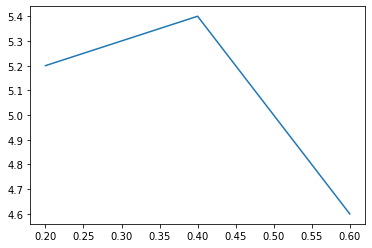

In [40]:
plt.plot(rango, [v[0] for v in valores])

### Results

Optimum value for $lambda$ converges to:

In [41]:
lambda_opt = 0.4

Lagrangian value at optimum point:

In [42]:
L_opt = L(lambda_opt)
L_opt[0]

<ipython-input-32-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


5.400000000000001

Selected arcs:

In [43]:
L_opt[1].x

array([1., 0., 0., 1., 0., 0., 0.])

In [44]:
print_path(gen_graph, L_opt[1].x)

" -> ('s', '2') -> ('2', 't') -> "

With known selected arcs and using the primal objective function, it's easy to calculate primal objective function value:

In [45]:
f_obj_primal = c @ L_opt[1].x
f_obj_primal

7.0

Primal objetive function represents total distance to travel from s to t.

Total time spent from s to t: 

In [46]:
T_total = t_j[0] @ L_opt[1].x
T_total

4.0

## Ex. 11 - SP time-restricted with the subgradient method 

### Problem data

Data is the same as Ex. 10. Also, I will use the same L(lambda) function definition.

In [47]:
c

array([2, 1, 2, 5, 2, 1, 2])

Travel times:

In [48]:
t_j

array([[3, 1, 3, 1, 3, 3, 5]])

Max. time:

In [49]:
T = 8

Arc-Node matrix:

In [50]:
A

array([[ 1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  1,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  1],
       [ 0,  0,  0, -1,  0, -1, -1]])

Node balance:

In [51]:
b

array([ 1.,  0.,  0.,  0.,  0., -1.])

D. V. bounds:

In [52]:
limites

[(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

### Subgradient procedure

In [53]:
def L(lambda_):
    c_moño = c + t_j * lambda_
    r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')
    
    return -lambda_*T+r.fun, r

In [54]:
def search_subgradient(lambda_inicial, tol=0.01):
    lambda_ = lambda_inicial

    diff = tol+1
    step = 0
    while abs(diff) > tol:
        l, res = L(lambda_)
        x_opt = res.x
        fun_primal = t_j[0] @ x_opt

        gradiente_lambda = t_j[0] @ x_opt - T
        step +=1
        diff = gradiente_lambda/step
        lambda_ += diff
        #print("Paso: {0}  lambda:{1:.4f} Fun {2:.1f} Primal {3:.1f} Arcos: {4}".format(step, lambda_, res.fun, fun_primal, str(x_opt)))
        
    return lambda_, res, step


In [55]:
lambda_final, res, steps = search_subgradient(0, 0.001)

lambda_final

<ipython-input-53-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


0.39847813247158115

### Results

Lambda Final value after iterations:

In [56]:
lambda_final

0.39847813247158115

Steps:

In [57]:
steps

1000

Selected Arcs:

In [58]:
res.x

array([1., 0., 1., 0., 0., 1., 0.])

In [59]:
print_path(gen_graph, res.x)

" -> ('s', '2') -> ('2', '4') -> ('4', 't') -> "

With known selected arcs and using the primal objective function, it's easy to calculate primal objective function value:

In [60]:
f_obj_primal = c @ res.x
f_obj_primal

5.0

Primal objetive function represents total distance to travel from s to t.

Total time spent from s to t: 

In [61]:
T_total = t_j[0] @ res.x
T_total

9.0

### Conclussions

Subgradient method gives us a path to find lambda values on relaxed problem.

Relaxed problem solution is very sensitive to lambda value and can fail to honor some restrictions , so a complementary method can be useful to find primal optimal solution.

For example, we have found a lambda value of:

In [62]:
lambda_final

0.39847813247158115

The selectec arcs:

In [63]:
x = L(lambda_final)[1].x
x

<ipython-input-53-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


array([0., 1., 0., 0., 1., 0., 1.])

With a travel time of:

In [64]:
t_j[0] @ x

9.0

But with lambda = 0.39:

In [65]:
x = L(0.39)[1].x
x

<ipython-input-53-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


array([1., 0., 1., 0., 0., 1., 0.])

With a travel time of:

In [66]:
t_j[0] @ x

9.0

Both of this solutions fails to honor restriction T < 8 hs.

But with lambda = 0.405:

In [67]:
x = L(0.405)[1].x
x

<ipython-input-53-65f143c2ffd3>:3: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  r = linprog(c=c_moño, A_eq = A, b_eq = b, bounds = limites, method='revised simplex')


array([1., 0., 0., 1., 0., 0., 0.])

With a travel time of:

In [68]:
t_j[0] @ x

4.0

That solution respects al restrictions.